<a href="https://colab.research.google.com/github/UrbanGISer/XGeoML/blob/main/XGeoML_Google_Colab_Best_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Geospatial Machine Learning Model
Lingbo Liu

Center for Geographic Analysis, Harvard University

Lingboliu@fas.harvard.edu

# 1 Create Synthetic Data

## 1-1 Create Data

In [1]:
import numpy as np
import pandas as pd
import math
# Grid setup (assuming these values are already defined)
grid_size = 30
u = np.repeat(np.arange(1, grid_size + 1), grid_size)
v = np.tile(np.arange(1, grid_size + 1), grid_size)

n=grid_size **2
np.random.seed(1234567)
x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = np.random.normal(loc=0, scale=1, size=n)
x4 = np.random.normal(loc=0, scale=1, size=n)
x5 = np.random.normal(loc=0, scale=1, size=n)
x6 = np.random.normal(loc=0, scale=1, size=n)
epsilon = np.random.normal(loc=0, scale=0.5, size=n)


# 1-Degree for linear gradient
angle_degrees = 45
angle_radians = np.radians(angle_degrees)

# 1-Linear discrete band
n_bands = 10

# Calculate increase X Y
dx = np.cos(angle_radians)
dy = np.sin(angle_radians)

# Projection
X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
projection = dx * X + dy * Y

# Normal [0, 1]
alpha1 = (projection - np.min(projection)) / (np.max(projection) - np.min(projection))
alpha2 = np.floor(alpha1 * n_bands) / n_bands

beta_linear= alpha1.flatten()
beta_lineardiscrete = alpha2.flatten()

# 2-Cosine
scale= 2
GS=grid_size/scale

beta_cos = 1 + 2 * (np.cos(math.pi * u / grid_size) * np.cos(math.pi * v / grid_size))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat1 = beta_cos.flatten()


beta_cos = 1 + 2 * (np.cos(math.pi * u / GS) * np.cos(math.pi * v / GS))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat2 = beta_cos.flatten()


# 3. Circular Gradient
radius_k=10
position_x=2
position_y=2

center_x, center_y = grid_size / position_x, grid_size / position_y  # center of the circle
radius = grid_size *radius_k  # radius of the circle
Y, X = np.ogrid[:grid_size, :grid_size]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
alpha3 = np.clip(1 - dist_from_center / radius, 0, 1)


# alpha3 /= (alpha3 - np.min(alpha3)) / (np.max(alpha3) - np.min(alpha3))
beta_circular_flat = alpha3.flatten()

# 4. Kernel Density Gradient (alpha4) with manual kernels
# Random Generate
# n_points = 3
# kernel_s=3
# kernel_e=10
# kernel_radii = np.random.uniform(kernel_s, kernel_e, n_points)  # different kernel radii for each point
# points = np.vstack([np.random.uniform(0, grid_size, n_points), np.random.uniform(0, grid_size, n_points)])
kernel_radii = np.array([7, 3, 5 ])
points = np.array([[ 8,  10,  25],
       [11, 28, 4]])

# Initialize alpha4 grid
alpha4 = np.zeros((grid_size, grid_size))

# Apply a Gaussian kernel to each point and sum the results
for point, radius in zip(points.T, kernel_radii):
    Y, X = np.ogrid[:grid_size, :grid_size]
    dist_from_point = np.sqrt((X - point[0])**2 + (Y - point[1])**2)
    gaussian = np.exp(-(dist_from_point**2 / (2. * radius**2)))
    alpha4 += gaussian

# alpha4 /= (alpha4 - np.min(alpha4)) / (np.max(alpha4) - np.min(alpha4))
alpha4_flat = alpha4.flatten()


df = pd.DataFrame({
    'u': u,
    'v': v,
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'x5': x5,
    'x6': x6,
    'e': epsilon,
    'b_linear': beta_linear,
    'b_lineardiscrete': beta_lineardiscrete,
    'b_cos_basic': beta_cos_flat1,
    'b_cos_ad': beta_cos_flat2,
    'b_circular': beta_circular_flat,
    'b_poly': alpha4_flat,
})




In [10]:
min_values = df.min()
max_values = df.max()

min_range = 0
max_range = 5

for column in ['b_linear','b_lineardiscrete','b_cos_basic','b_cos_ad','b_circular','b_poly']:
    df[column] = min_range + (df[column] - min_values[column]) * (max_range - min_range) / (max_values[column] - min_values[column])


In [11]:
df['y'] = df['b_linear'] * df['x1'] + df['x2'] * df['b_circular'] + df['x3']**2 * df['b_cos_basic'] + df['x4']**3 * df['b_poly']+df['e']

In [ ]:
df.head(5)

,u,v,x1,x2,x3,x4,x5,x6,e,b_linear,b_lineardiscrete,b_cos_basic,b_cos_ad,b_circular,b_poly,y
0,1,1,-0.514625,0.688297,0.992160,0.620480,1.068074,1.142192,-0.054045,0.000000,0.0,4.972609,4.891932,0.000000,0.719144,5.012690
1,1,2,-0.449554,-0.391767,-0.556702,0.386716,-0.224860,0.788291,-0.623987,0.086207,0.0,4.931786,4.733956,0.163794,0.838430,0.850026
2,1,3,1.734621,-0.240266,0.449129,1.595730,0.474081,-0.279895,0.035431,0.172414,0.0,4.864244,4.478345,0.321444,0.957690,5.129849
3,1,4,0.643380,-0.070372,0.063307,0.408018,-0.153461,-1.031303,-0.281256,0.258621,0.0,4.770724,4.136271,0.472307,1.071801,-0.056179
4,1,5,0.026139,0.442559,1.255714,-1.568991,-0.745217,-0.004208,-0.458297,0.344828,0.0,4.652251,3.722685,0.615685,1.175354,2.619219


In [ ]:
df.to_csv("/content/df.csv")

## 1-2 Visualization

In [2]:
truebeta= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

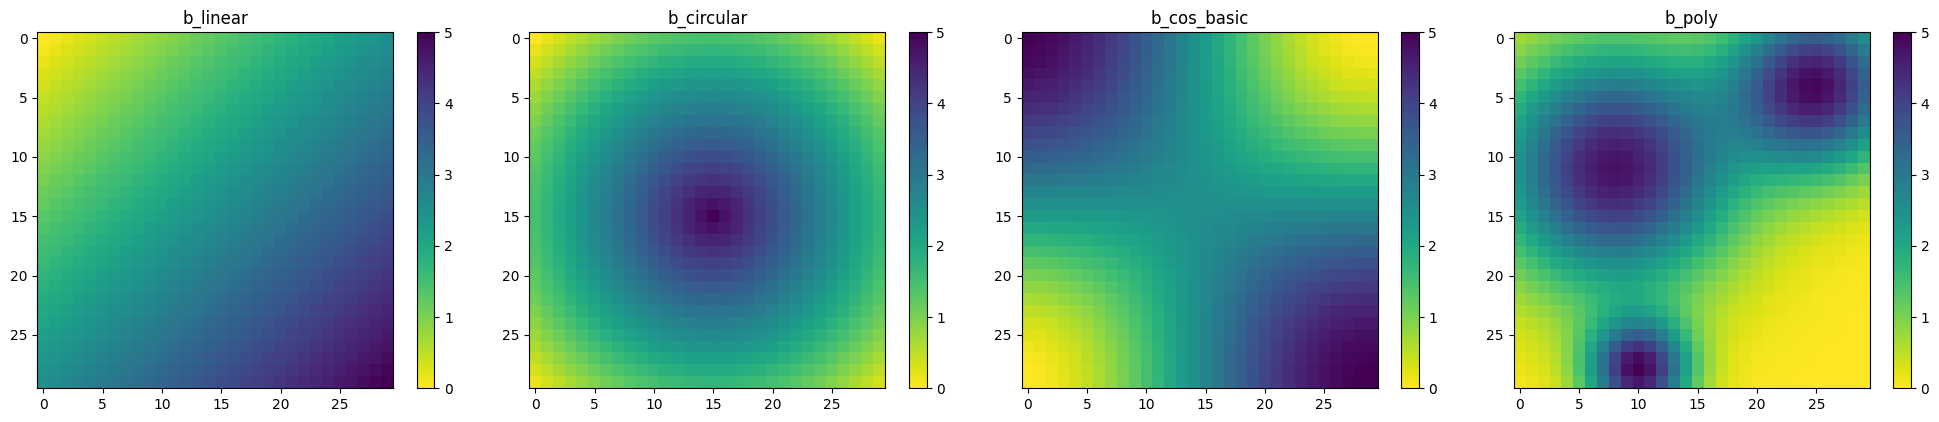

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    plt.colorbar(im, ax=ax,
                #  label='Value',
                 )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

data_list = [df.pivot(index='u', columns='v', values=i) for i in truebeta]
titles =truebeta

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)


plt.tight_layout()
plt.show()


# 2 XGeoML

## 2-1 Install Packages- XGeoML

key Dependence: sklearn, lime,shap

In [3]:
!pip install XGeoML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 17.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=cfe30b1b1f9ba422827c5fbb35fa067cb33548773c486f2b17e2ce2297131aee
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
!pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.7 MB/s eta 0:00:00


In [ ]:
# Check available modules
from sklearn.utils import all_estimators

# 获取所有的分类器
classifiers = all_estimators(type_filter='classifier')
print("Classifiers:")
for name, _ in classifiers:
    print("-", name)

# 获取所有的回归器
regressors = all_estimators(type_filter='regressor')
print("\nRegressors:")
for name, _ in regressors:
    print("-", name)

Classifiers:
- AdaBoostClassifier
- BaggingClassifier
- BernoulliNB
- CalibratedClassifierCV
- CategoricalNB
- ClassifierChain
- ComplementNB
- DecisionTreeClassifier
- DummyClassifier
- ExtraTreeClassifier
- ExtraTreesClassifier
- GaussianNB
- GaussianProcessClassifier
- GradientBoostingClassifier
- HistGradientBoostingClassifier
- KNeighborsClassifier
- LabelPropagation
- LabelSpreading
- LinearDiscriminantAnalysis
- LinearSVC
- LogisticRegression
- LogisticRegressionCV
- MLPClassifier
- MultiOutputClassifier
- MultinomialNB
- NearestCentroid
- NuSVC
- OneVsOneClassifier
- OneVsRestClassifier
- OutputCodeClassifier
- PassiveAggressiveClassifier
- Perceptron
- QuadraticDiscriminantAnalysis
- RadiusNeighborsClassifier
- RandomForestClassifier
- RidgeClassifier
- RidgeClassifierCV
- SGDClassifier
- SVC
- StackingClassifier
- VotingClassifier

Regressors:
- ARDRegression
- AdaBoostRegressor
- BaggingRegressor
- BayesianRidge
- CCA
- DecisionTreeRegressor
- DummyRegressor
- ElasticNet
- E

## 2-2 Generate Spatial Weight

In [5]:
from XGeoML import w_matrix, fast_train, train_model

`fix=False` : using adaptive bandwidth, e.g using the maximum distance in 30 nearest  neigboring locations (bandwidth=30).

`fix=True` : using bandwidht as distance threshold (e.g.,bandwidth=30 km)

`Kernel_type`:['Binary','Gaussian','GaussianBinary']

In [6]:
weights=w_matrix.spatial_weight(df, "u", "v", fix=False, bandwidth=100, kernel_type='Binary')

We can also use libpysal to generate more spatial weight

In [ ]:
import libpysal.weights as lw
points = df[['u', 'v']].values
w=lw.DistanceBand(points,threshold=6,binary=False)
weightpysal=w_matrix.from_libpysal(w)

divide by zero encountered in reciprocal


## 2-3 Predict and Explain

In [7]:
# 01 Define key variables
feature_names=['x1','x2','x3','x4']
target_name="y"
explainer_names = ["LIME","SHAP", 'Importance']
turebeta= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

In [8]:
# o2 import  sklearn ML model
from sklearn.ensemble import  GradientBoostingRegressor
model=GradientBoostingRegressor

### Predict

In [ ]:
#03 Predict all with  parallel computation, 'predy' for the result
dfx=fast_train.predict(df, feature_names, target_name, weights, model)

In [13]:
from sklearn.metrics  import r2_score

In [14]:
# Evaluation for LOO R2
r2_score(dfx.y,dfx.predy)

0.6898284162837547

In [ ]:
#04 Explain all
dfe=fast_train.explain(df, feature_names, target_name, weights,model, explainer_names)

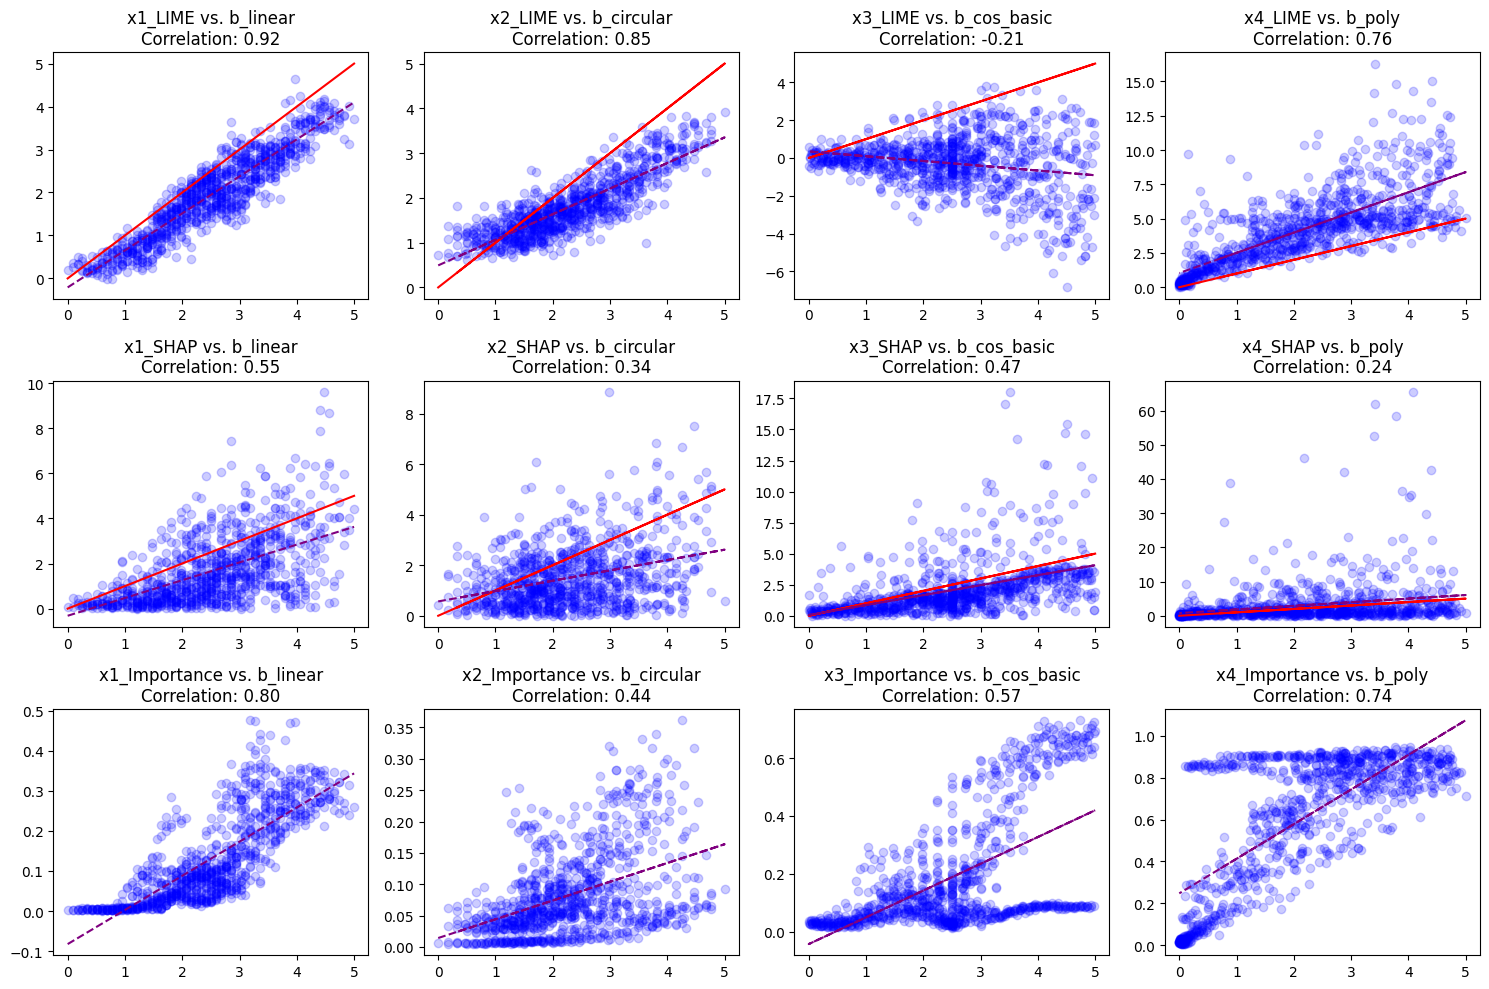

In [16]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

columnsvar = [var + '_' + explainer for explainer in explainer_names for var in feature_names]

for idx, ax in enumerate(axes.flatten()):
    feature_column = columnsvar[idx]
    b_column = turebeta[idx % 4]

    # 获取数据
    y = dfe[feature_column]
    x = dfe[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')



    if idx < 8:
        ax.plot(x, x, color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
        ax.plot(x, slope * x + intercept, color='purple', linestyle='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    else:
        ax.plot(x, slope * x + intercept, color='purple', linestyle='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)

# 调整布局
plt.tight_layout()
plt.show()

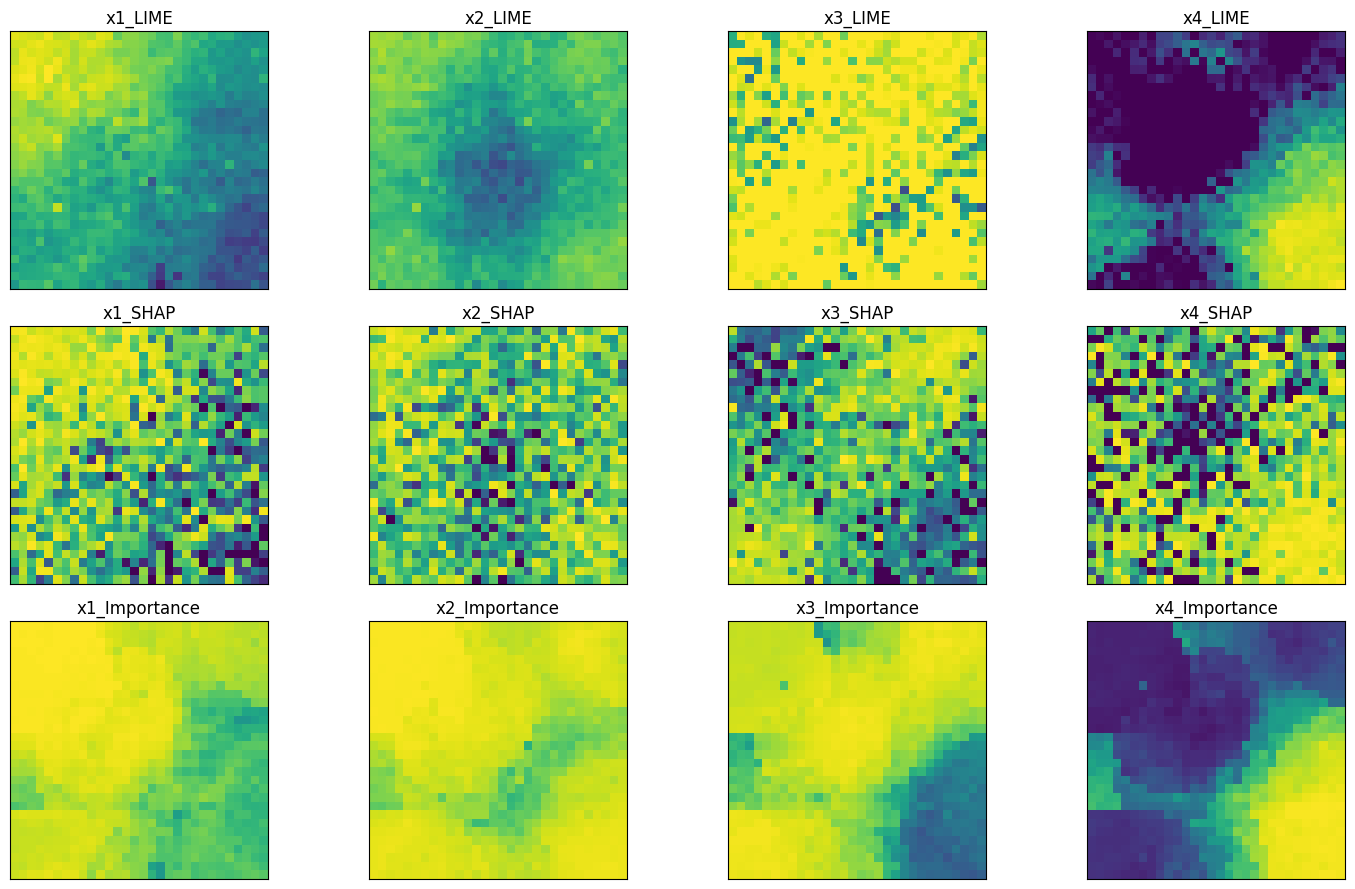

In [17]:
import matplotlib.pyplot as plt

columnsvar = [var + '_' + explainer for explainer in explainer_names for var in feature_names]

def plot_heatmap(ax, data, title,vmax=5):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=vmax)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(3, 4, figsize=(15, 9))

mapcolumn = columnsvar

# 数据和标题
data_list = [dfe.pivot(index='u', columns='v', values=i) for i in mapcolumn]
titles =mapcolumn

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
    if idx >= 8:
        plot_heatmap(ax, data, title, vmax=1)
    else:
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

### SHAP-GWR as GeoShapley

In [ ]:
!pip install mgwr

In [ ]:
import mgwr

In [19]:
df_explain1=fast_train.explain(df, feature_names, target_name, weights,model, explainer_names,xcoord='u',ycoord='v',shap_gwr=True)


Computing Prediction: 100%|██████████| 900/900 [01:55<00:00,  7.82it/s]

Apply GWR on SHAP: 100%|██████████| 4/4 [00:19<00:00,  4.80s/it]


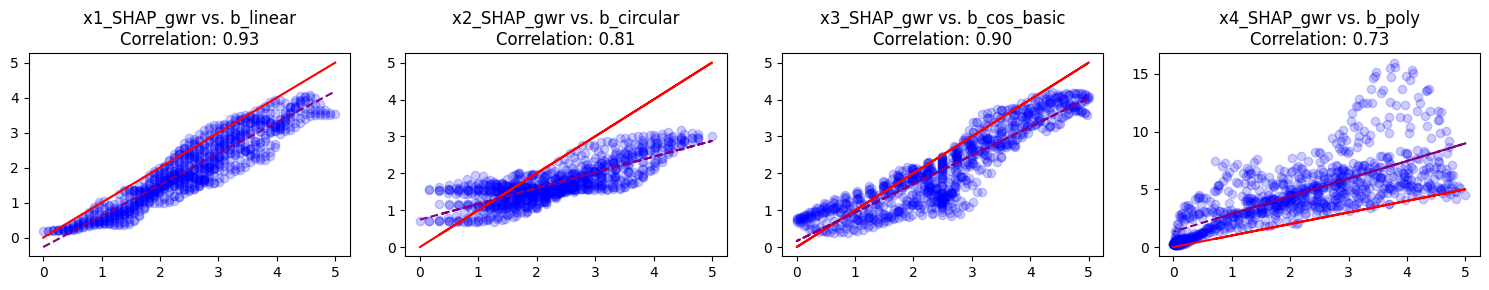

In [20]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

columnsvar = [var + '_SHAP_gwr' for var in feature_names]

for idx, ax in enumerate(axes.flatten()):
    feature_column = columnsvar[idx]
    b_column = turebeta[idx % 4]

    # 获取数据
    y = df_explain1[feature_column]
    x = df_explain1[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')



    if idx < 8:
        ax.plot(x, x, color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
        ax.plot(x, slope * x + intercept, color='purple', linestyle='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    else:
        ax.plot(x, slope * x + intercept, color='purple', linestyle='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)

# 调整布局
plt.tight_layout()
plt.show()

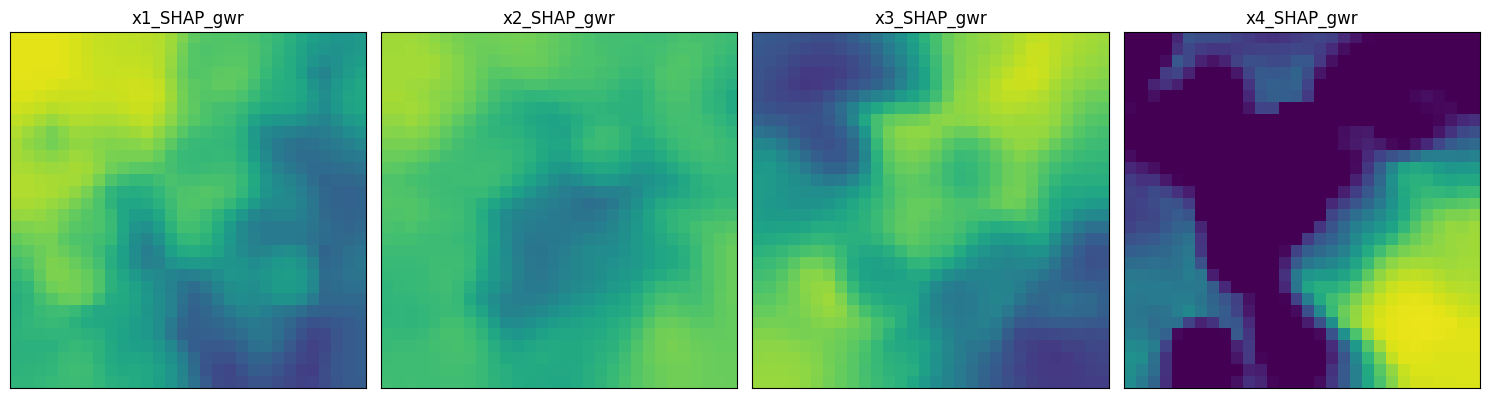

In [22]:
import matplotlib.pyplot as plt

columnsvar = [var + '_SHAP_gwr' for var in feature_names]

def plot_heatmap(ax, data, title,vmax=5):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=vmax)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(15, 9))

mapcolumn = columnsvar

# 数据和标题
data_list = [df_explain1.pivot(index='u', columns='v', values=i) for i in mapcolumn]
titles =mapcolumn

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
    if idx >= 8:
        plot_heatmap(ax, data, title, vmax=1)
    else:
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

### Partial Dependence

In [ ]:
# 06 Partial Dependence Estimation, Even will genearte new data in the sampling bin
df_pd=fast_train.partial_dependence(df, model,  feature_names, target_name, weights,num_samples=50,even=False)

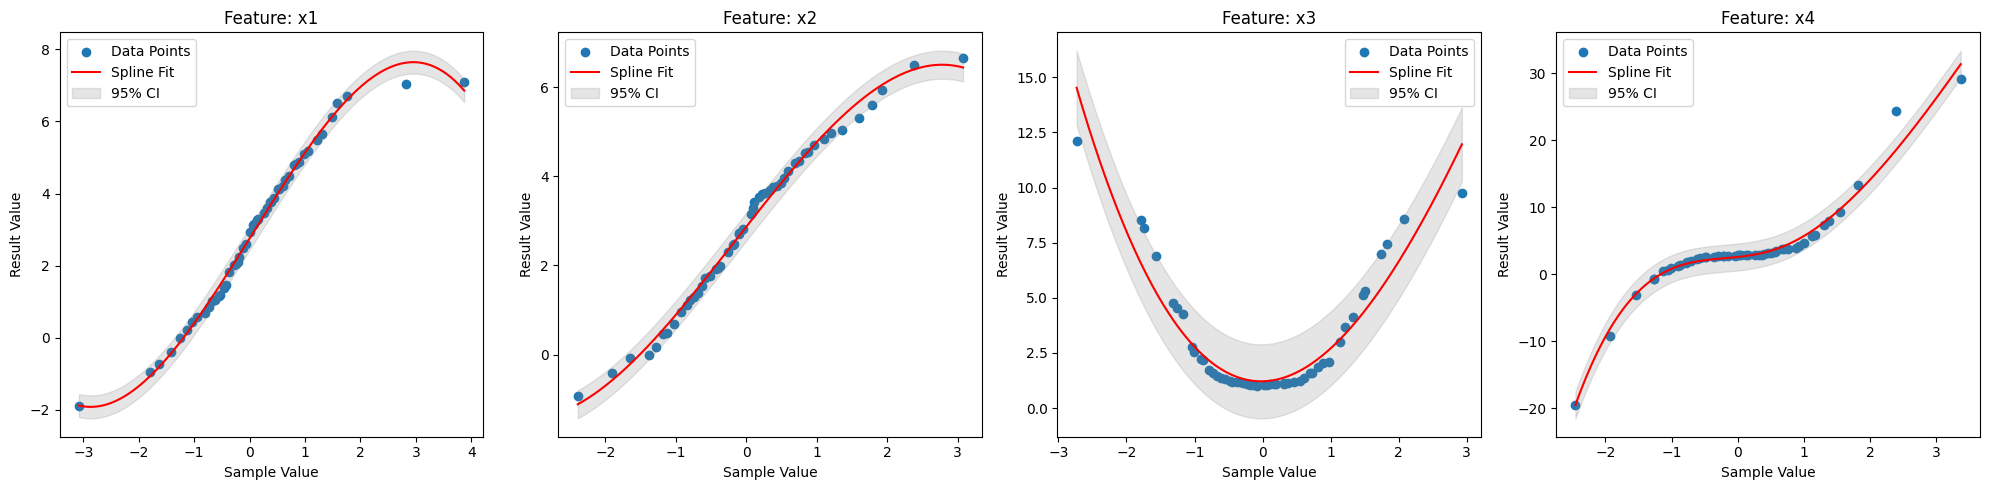

In [24]:
#08 Partial Dependence plot
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy import stats


fig, axes = plt.subplots(nrows=1, ncols=len(feature_names), figsize=(20, 5))

for i, feature in enumerate(feature_names):
    sample_col= feature +"_sample"
    result_col=feature +"_estimate"
    x = df_pd[sample_col].values
    y = df_pd[result_col].values

    axes[i].scatter(x, y, label='Data Points')

    spline = UnivariateSpline(x, y, s=len(x))

    x_smooth = np.linspace(x.min(), x.max(), 200)
    y_spline = spline(x_smooth)

    axes[i].plot(x_smooth, y_spline, color='red', label='Spline Fit')

    y_fit = spline(x)
    resid = y - y_fit
    sigma = np.std(resid)

    ci = sigma * stats.t.ppf(0.975, len(y)-1)  # 95% CI
    axes[i].fill_between(x_smooth, y_spline-ci, y_spline+ci, color='grey', alpha=0.2, label='95% CI')

    axes[i].set_title(f'Feature: {feature}')
    axes[i].set_xlabel('Sample Value')
    axes[i].set_ylabel('Result Value')
    axes[i].legend()

plt.tight_layout()
plt.show()


## 2-3 Case Study research

In [ ]:
# A case study from “Computational Methods and GIS Applications in Social Science, 3rd Edition” authored by Fahui Wang and Lingbo Liu.
# Chapter 8
# also refer to :Wang, F. Job Access and Homicide Patterns in Chicago: An Analysis at Multiple Geographic Levels Based on Scale-Space Theory. J Quant Criminol 21, 195–217 (2005). https://doi.org/10.1007/s10940-005-2492-5

import pandas as pd
df=pd.read_csv('https://raw.githubusercontent.com/UrbanGISer/XGeoML/main/chicagocmgis.csv')

In [ ]:
df.columns

Index(['CNTYBNA', 'FACTOR1', 'FACTOR2', 'FACTOR3', 'JA', 'CT89_91', 'POPU',
       'HomiRate', 'LnHomiRate', 'xcoord', 'ycoord', 'poverty',
       'public_assistance', 'female_headed', 'unemployment', 'new_residents',
       'renter-occupied', 'no_high_school', 'crowded_households', 'black',
       'latino'],
      dtype='object')

In [ ]:
# 01 Define key variables
feature_names=['poverty', 'public_assistance', 'female_headed', 'unemployment', 'new_residents',  'renter-occupied', 'no_high_school', 'crowded_households', 'black', 'latino', 'JA']
target_name="HomiRate"
explainer_names = ["LIME","SHAP", 'Importance']


### Bandwidth Searching

In [ ]:
# 05 Bandwidth Searching
eval_bandwidth = pd.DataFrame()
for i in range(10):
    k=40+i*40
    for j in range(3):
        weights=w_matrix.spatial_weight(df, "xcoord", "ycoord", fix=False, bandwidth=k, kernel_type='Binary')
        dfx=fast_train.predict(df, feature_names, target_name, weights, model)
        r22=r2_score(dfx.HomiRate,dfx.predy)
        eval_bandwidth.loc[i, j]=r22

Computing Prediction: 100%|██████████| 845/845 [01:55<00:00,  7.31it/s]


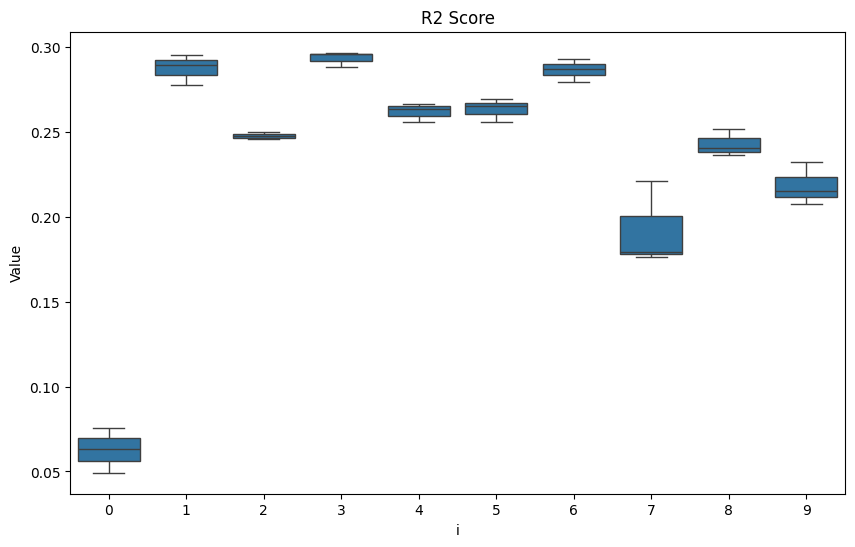

In [ ]:
# 06 Visual bandwidth searching
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_long = eval_bandwidth.stack().reset_index()
df_long.columns = ['i', 'j', 'value']

plt.figure(figsize=(10, 6))
sns.boxplot(x='i', y='value', data=df_long)
plt.title('R2 Score')
plt.xlabel('i')
plt.ylabel('Value')
plt.show()

### Predcit and Explain

In [ ]:
weights=w_matrix.spatial_weight(df, "xcoord", "ycoord", fix=False, bandwidth=160, kernel_type='Binary')

In [ ]:
# import libpysal.weights as lw
# points = df[['u', 'v']].values
# w=lw.DistanceBand(points,threshold=6,binary=False)
# weightpysal=w_matrix.from_libpysal(w)

divide by zero encountered in reciprocal


In [ ]:
import libpysal.weights as lw
points = df[["xcoord", "ycoord"]].values
w=lw.Kernel(points,fixed=False, k=160, function='gaussian')
weightpysal=w_matrix.from_libpysal(w)

In [ ]:
#03 Predict all with  parallel computation, 'predy' for the result
dfx=fast_train.predict(df, feature_names, target_name, weights, model)


Computing Prediction:  66%|██████▌   | 554/845 [00:48<00:34,  8.56it/s]

In [ ]:
from sklearn.metrics import r2_score
r2_score(dfx.predy,dfx.HomiRate)

-0.6589220057513143

In [ ]:
#04 Explain all
dfe=fast_train.explain(df, feature_names, target_name, weights,model, explainer_names)

Computing Prediction: 100%|██████████| 845/845 [01:41<00:00,  8.29it/s]


In [ ]:
import geopandas as gp
dfmap=gp.read_file('https://raw.githubusercontent.com/UrbanGISer/XGeoML/main/Chicago.zip')

In [ ]:
dfe['CNTYBNA'] = dfe['CNTYBNA'].apply(lambda x: str(x).zfill(7))

In [ ]:
df_merged = pd.merge(dfmap, dfe, on='CNTYBNA')

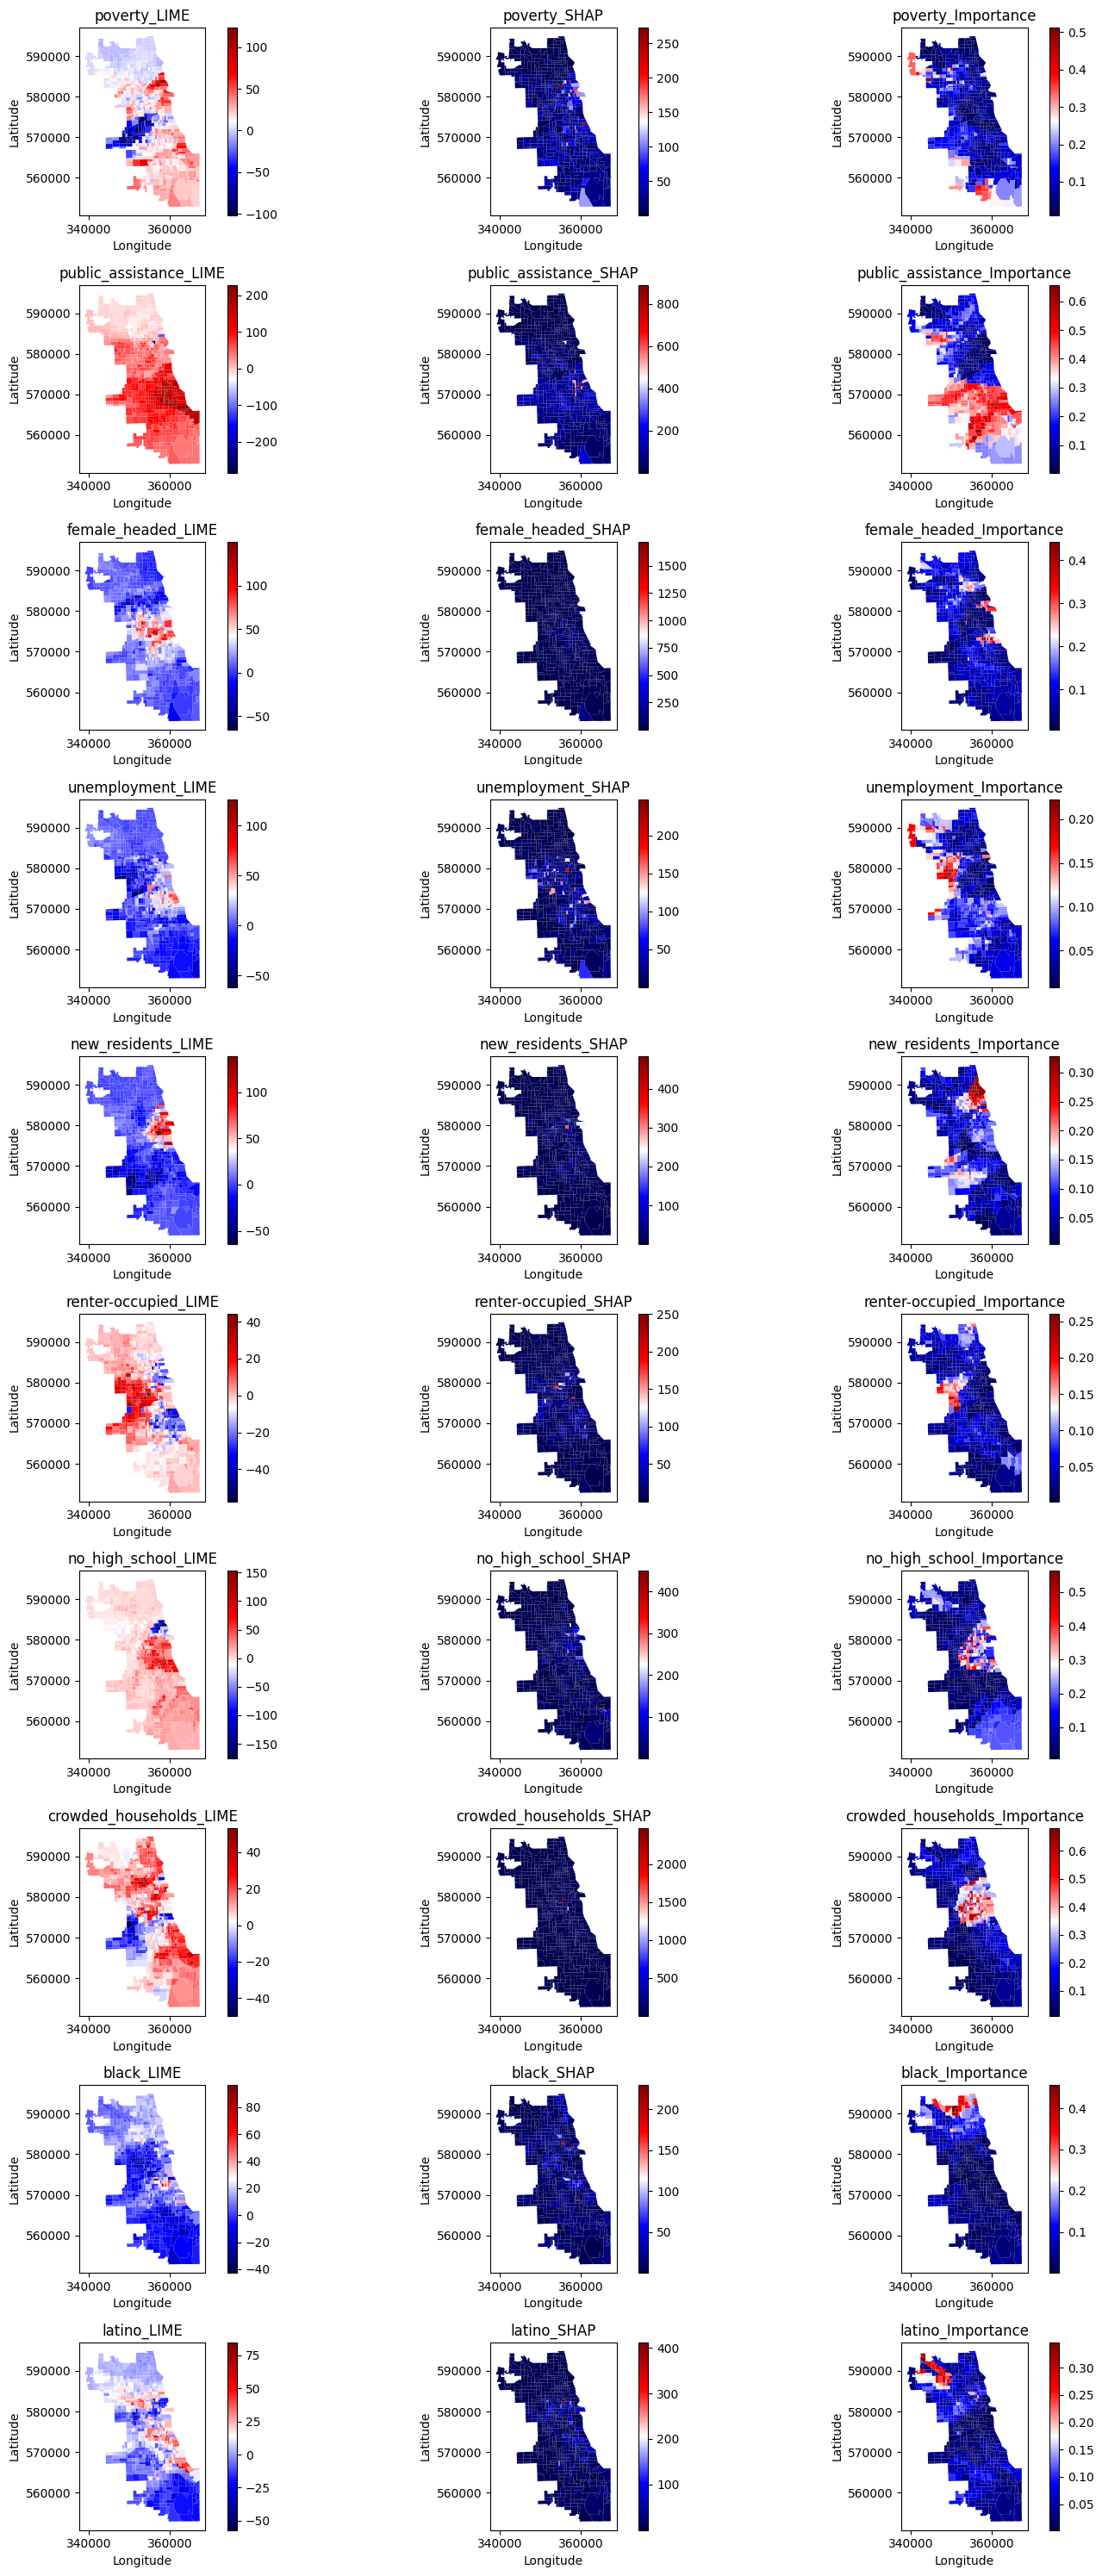

In [ ]:
# prompt: 可视化df_merged 地图 并使用 geopandas plot 对所有包含，_LIME,_SHAP, _Importance 的字段进行绘图,f分成3列，颜色使用 seismic

import geopandas as gpd
import matplotlib.pyplot as plt

# Plot the map
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 30))  # 设置为10行3列

for i, var in enumerate(feature_names):  # 使用 enumerate 获取索引
    for j, col_suffix in enumerate(['_LIME', '_SHAP', '_Importance']):  # 迭代3个列后缀
        col_name = f'{var}' + col_suffix  # 构造列名
        df_merged.plot(column=col_name, ax=axes[i][j], legend=True, cmap='seismic')  # 使用索引 i 和 j
        axes[i][j].set_title(col_name)
        axes[i][j].set_xlabel('Longitude')
        axes[i][j].set_ylabel('Latitude')

plt.tight_layout()  # 调整布局以防止重叠
plt.show()

In [ ]:
# 06 Partial Dependence Estimation, Even will genearte new data in the sampling bin
df_pd=fast_train.partial_dependence(df, model,  feature_names, target_name, weights,num_samples=150,even=True)

Sample size: 150. 632 used for Partial Dependence Estimation


Computing importances: 100%|██████████| 632/632 [04:30<00:00,  2.34it/s]


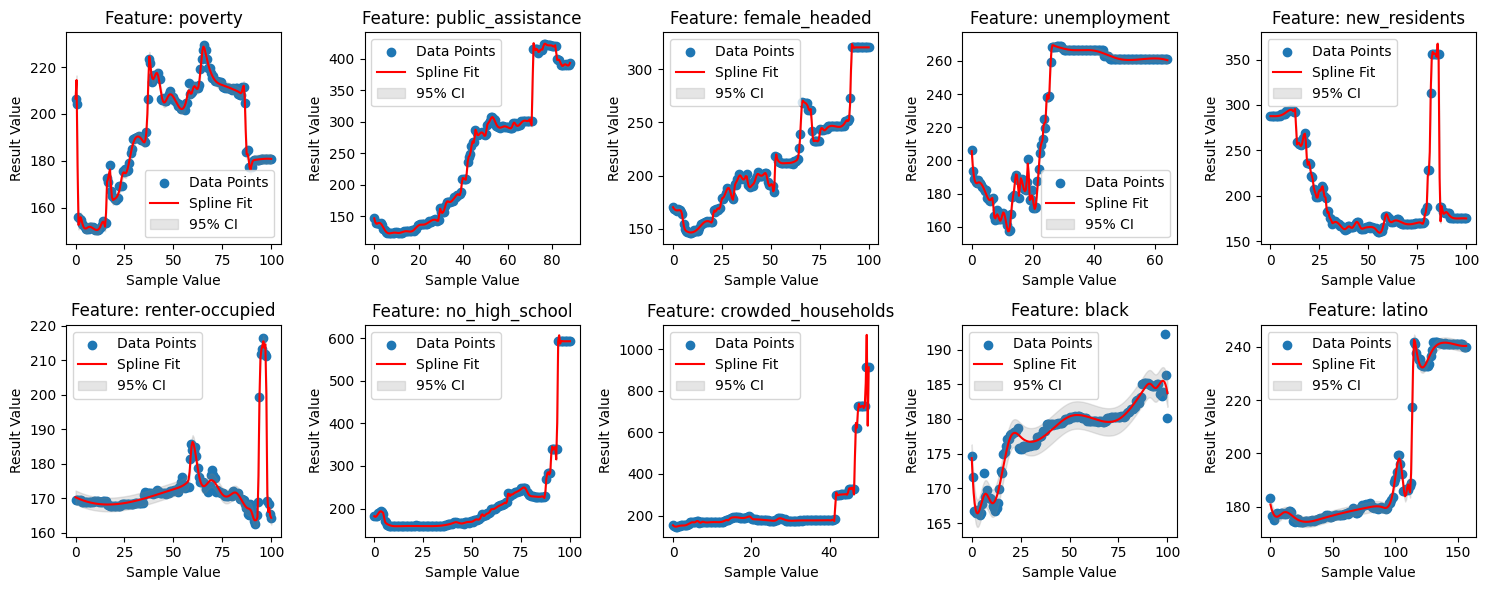

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy import stats

# Calculate subplot layout parameters
num_features = len(feature_names)
cols_per_row = 5 # 每行的图数量
rows = (num_features + cols_per_row - 1) // cols_per_row  # 计算总的行数

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(15, 3 * rows))

for i, feature in enumerate(feature_names):
    row = i // cols_per_row  # 计算当前特征所在的行
    col = i % cols_per_row  # 计算当前特征所在的列

    sample_col = feature + "_sample"
    result_col = feature + "_estimate"
    x = df_pd[sample_col].values
    y = df_pd[result_col].values
     # Rescale y values based on y mean

    axes[row, col].scatter(x, y, label='Data Points')

    spline = UnivariateSpline(x, y, s=len(x))

    x_smooth = np.linspace(x.min(), x.max(), 200)
    y_spline = spline(x_smooth)

    axes[row, col].plot(x_smooth, y_spline, color='red', label='Spline Fit')

    y_fit = spline(x)
    resid = y - y_fit
    sigma = np.std(resid)

    ci = sigma * stats.t.ppf(0.975, len(y)-1)  # 95% CI
    axes[row, col].fill_between(x_smooth, y_spline-ci, y_spline+ci, color='grey', alpha=0.2, label='95% CI')

    axes[row, col].set_title(f'Feature: {feature}')
    axes[row, col].set_xlabel('Sample Value')
    axes[row, col].set_ylabel('Result Value')
    axes[row, col].legend()

# Hide unused subplots
for i in range(num_features, rows * cols_per_row):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 3.3 MB/s eta 0:00:00


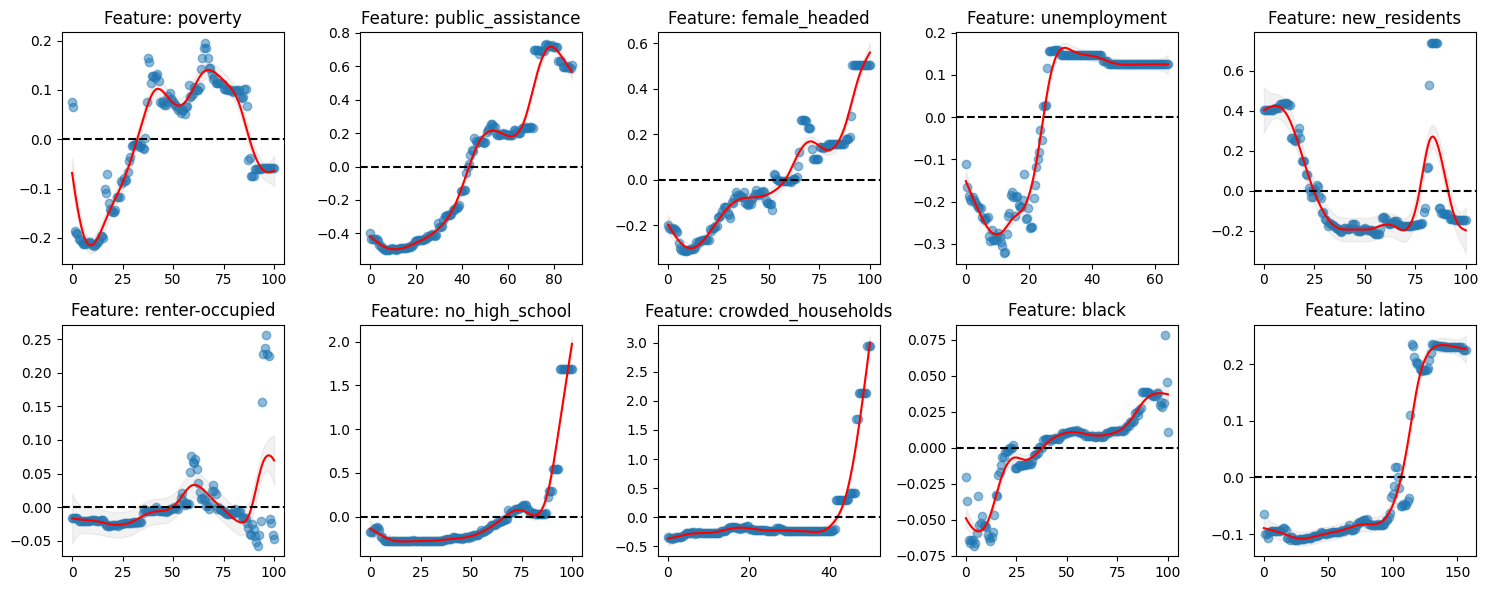

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM
from scipy import stats

# Calculate subplot layout parameters
num_features = len(feature_names)
cols_per_row = 5  # 每行的图数量
rows = (num_features + cols_per_row - 1) // cols_per_row  # 计算总的行数

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(15, 3 * rows))

for i, feature in enumerate(feature_names):
    row = i // cols_per_row  # 计算当前特征所在的行
    col = i % cols_per_row  # 计算当前特征所在的列

    sample_col = feature + "_sample"
    result_col = feature + "_estimate"
    x = df_pd[sample_col].values
    y = df_pd[result_col].values

    # Rescale y values based on y mean
    y_mean = np.mean(y)
    y_rescaled = (y - y_mean) / y_mean

    axes[row, col].scatter(x, y_rescaled, label='Data Points', alpha=0.5)

    gam = LinearGAM().fit(x, y_rescaled)
    x_smooth = np.linspace(x.min(), x.max(), 200)
    y_smooth = gam.predict(x_smooth)

    axes[row, col].plot(x_smooth, y_smooth, color='red', label='GAM Fit')

    ci = gam.confidence_intervals(x_smooth, width=0.95)
    axes[row, col].fill_between(x_smooth, ci[:, 0], ci[:, 1], color='grey', alpha=0.1, label='95% CI')

    # Plot y=0 dashed line
    axes[row, col].axhline(y=0, color='black', linestyle='--', label='y=0')

    axes[row, col].set_title(f'Feature: {feature}')
    # axes[row, col].set_xlabel('Sample Value')
    # axes[row, col].set_ylabel('(y - mean(y)) / mean(y)')

    # 关闭图例
    axes[row, col].legend().set_visible(False)

# Hide unused subplots
for i in range(num_features, rows * cols_per_row):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()
